In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from pandas.api.types import is_numeric_dtype

from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split, KFold

In [2]:
df_orig = pd.read_csv('data.csv')
df_orig.head().T

,0,1,2,3,4
Make,BMW,BMW,BMW,BMW,BMW
Model,1 Series M,1 Series,1 Series,1 Series,1 Series
Year,2011,2011,2011,2011,2011
Engine Fuel Type,premium unleaded (required),premium unleaded (required),premium unleaded (required),premium unleaded (required),premium unleaded (required)
Engine HP,335.0,300.0,300.0,230.0,230.0
Engine Cylinders,6.0,6.0,6.0,6.0,6.0
Transmission Type,MANUAL,MANUAL,MANUAL,MANUAL,MANUAL
Driven_Wheels,rear wheel drive,rear wheel drive,rear wheel drive,rear wheel drive,rear wheel drive
Number of Doors,2.0,2.0,2.0,2.0,2.0
Market Category,"Factory Tuner,Luxury,High-Performance","Luxury,Performance","Luxury,High-Performance","Luxury,Performance",Luxury


For the rest of the homework, you'll need to use only these columns:

* `Make`,
* `Model`,
* `Year`,
* `Engine HP`,
* `Engine Cylinders`,
* `Transmission Type`,
* `Vehicle Style`,
* `highway MPG`,
* `city mpg`
* `MSRP`


### Data preparation

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0 
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable `above_average`

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`


In [3]:
columns = [
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]
target = 'above_average'
df = df_orig[columns]
df.columns = df.columns.str.lower().str.replace(' ', '_')
msrp_mean = df.msrp.mean()
df = df.fillna(0)
df[target] = (df.msrp > msrp_mean).astype(int)
df.drop(columns=['msrp'], inplace=True)
df.head()

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,above_average
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,1
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,1
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,0
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,0
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,0


In [4]:
seed = 1

In [5]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=seed)

y_train = df_train.pop(target)
y_val = df_val.pop(target)
y_test = df_test.pop(target)

tuple(df_temp.shape for df_temp in [df_train, df_val, df_test])

((7148, 9), (2383, 9), (2383, 9))

### Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `above_average` variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['engine_hp']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `engine_hp`
- `engine_cylinders`
- `highway_mpg`
- `city_mpg`

In [6]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_hp            float64
engine_cylinders     float64
transmission_type     object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
dtype: object

In [7]:
numeric = [col for col in df_train.columns if is_numeric_dtype(df_train[col]) and col != target]
df_train[numeric].dtypes

year                  int64
engine_hp           float64
engine_cylinders    float64
highway_mpg           int64
city_mpg              int64
dtype: object

In [8]:
for col in numeric:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        print(f'\tInverted values for {col=}')
        auc = roc_auc_score(y_train, -df_train[col])
    print(f'{col:16s} {auc=:.4f}')

year             auc=0.6876
engine_hp        auc=0.9171
engine_cylinders auc=0.7661
	Inverted values for col='highway_mpg'
highway_mpg      auc=0.6331
	Inverted values for col='city_mpg'
city_mpg         auc=0.6734


> **Answer 1**: `engine_hp`

### Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.678
- 0.779
- 0.878
- 0.979

In [9]:
dv = DictVectorizer()
X_train = dv.fit_transform(df_train.to_dict(orient='records'))
X_train.shape

(7148, 954)

In [10]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [11]:
X_val = dv.transform(df_val.to_dict(orient='records'))
X_val.shape

(2383, 954)

In [12]:
y_val_pred = model.predict_proba(X_val)[:, 1]
y_val_pred.shape, y_val_pred.mean()

((2383,), 0.278770533706969)

In [13]:
roc_auc_score(y_val, y_val_pred).round(4)

0.9797

> **Answer 2**: $0.979$

### Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [14]:
thresholds = np.linspace(0, 1, round(1/0.01 + 1))

Curves intersect at approx: t=0.48


/tmp/ipykernel_18540/3368770164.py:18: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


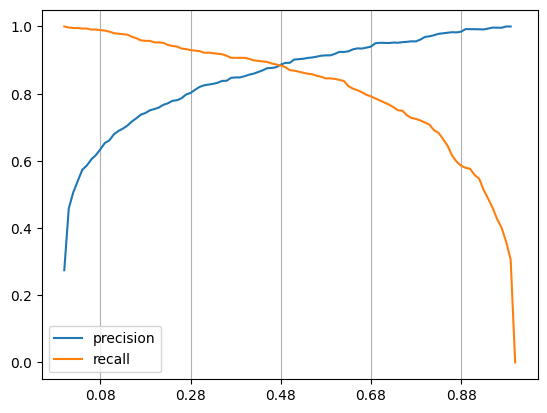

In [15]:
scores = []

pt_intersect = float('inf')
threshold_intersect = None

for t in thresholds:
    act_p = (y_val == 1)
    act_n = (y_val == 0)
    
    pred_p = (y_val_pred >= t)
    pred_n = (y_val_pred < t)
    
    tp = (act_p & pred_p).sum()
    tn = (act_n & pred_n).sum()
    fp = (act_n & pred_p).sum()
    fn = (act_p & pred_n).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, tp, tn, fp, fn, precision, recall))
    
    if abs(recall - precision) < pt_intersect:
        pt_intersect = abs(recall - precision)
        threshold_intersect = t
        
df_scores = pd.DataFrame(
    scores, 
    columns=[
        't', 
        'tp', 'tn', 'fp', 'fn',
        'p', 'r'
    ],
    index=thresholds
)

plt.plot(df_scores.t, df_scores.p, label='precision');
plt.plot(df_scores.t, df_scores.r, label='recall');
plt.xticks(np.linspace(0.08, 0.88, 5));
plt.grid(axis='x');
plt.legend();

print(f'Curves intersect at approx: t={threshold_intersect:.2f}')

> **Answer 3**: $0.48$

### Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.12
- 0.32
- 0.52
- 0.72

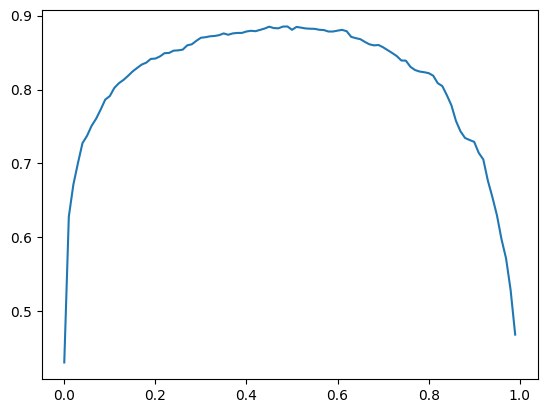

In [16]:
df_scores['F1'] = 2 * (df_scores.p * df_scores.r) / (df_scores.p + df_scores.r)

plt.plot(df_scores.t, df_scores.F1);

In [17]:
idx = df_scores.F1.idxmax()
df_scores.loc[idx, :]

t        0.490000
tp     575.000000
tn    1659.000000
fp      70.000000
fn      79.000000
p        0.891473
r        0.879205
F1       0.885296
Name: 0.49, dtype: float64

In [18]:
df_scores.F1.describe()

count    100.000000
mean       0.812203
std        0.093161
min        0.430688
25%        0.789958
50%        0.849277
75%        0.876085
max        0.885296
Name: F1, dtype: float64

> **Answer 4**: $0.49$

### Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

- 0.003
- 0.030
- 0.090
- 0.140

In [19]:
def kfold_scores(df, C=1.0):
    kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
    scores = []

    for train_idx, val_idx in kfold.split(df):
        df_t = df.iloc[train_idx]
        df_v = df.iloc[val_idx]

        y_t = df_t.pop(target)
        y_v = df_v.pop(target)

        dv = DictVectorizer()
        X_t = dv.fit_transform(df_t.to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_t, y_t)

        X_v = dv.transform(df_v.to_dict(orient='records'))
        y_v_pred = model.predict_proba(X_v)[:, 1]
        score = roc_auc_score(y_v, y_v_pred)
        scores.append(score)
    return np.array(scores)

In [20]:
scores = kfold_scores(df_train_full)
print(f'stdev of auc scores: {scores.std():.4f}')

stdev of auc scores: 0.0021


> **Answer 5**: $~0.003$

### Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.01, 0.1, 0.5, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [21]:
for C in [0.01, 0.1, 0.5, 10]:
    scores = kfold_scores(df_train_full, C=C)
    print(f'{C=:5.2f}, mean={scores.mean():.3f}, std={scores.std():.3f}')

C= 0.01, mean=0.952, std=0.003
C= 0.10, mean=0.972, std=0.002
C= 0.50, mean=0.977, std=0.002
C=10.00, mean=0.981, std=0.003


> **Answer 6**: $C=10$